In [1]:
import pandas as pd
import numpy as np
import threading
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import requests
import astral
from astral.sun import sun
from uszipcode import SearchEngine, Zipcode
from sklearn.linear_model import LinearRegression

Data from https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95
<br/>Long term: Add weather data

In [2]:
df = pd.read_csv(r'../data/Motor_Vehicle_Collisions_-_Crashes.csv')
df.head()

/home/yehuda/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,06/26/2017,22:00,MANHATTAN,10002,40.718270,-73.99072,POINT (-73.99072 40.71827),ALLEN STREET,BROOME STREET,NaN,...,Unspecified,NaN,NaN,NaN,3699702,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN
1,07/14/2017,13:17,NaN,NaN,40.783180,-73.94362,POINT (-73.94362 40.78318),FDR DRIVE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,3712558,Taxi,Sedan,NaN,NaN,NaN
2,07/04/2017,14:00,BRONX,10462,40.833557,-73.85774,POINT (-73.85774 40.833557),WESTCHESTER AVENUE,PUGSLEY AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,3705809,Sedan,Sedan,NaN,NaN,NaN
3,07/17/2017,21:03,MANHATTAN,10032,40.833843,-73.94851,POINT (-73.94851 40.833843),RIVERSIDE DRIVE,WEST 155 STREET,NaN,...,NaN,NaN,NaN,NaN,3713274,Sedan,NaN,NaN,NaN,NaN
4,06/26/2017,15:35,BROOKLYN,11203,40.654434,-73.92139,POINT (-73.92139 40.654434),REMSEN AVENUE,LINDEN BOULEVARD,NaN,...,Driver Inexperience,NaN,NaN,NaN,3702089,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1697572 entries, 0 to 1697571
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   CRASH DATE                     object 
 1   CRASH TIME                     object 
 2   BOROUGH                        object 
 3   ZIP CODE                       object 
 4   LATITUDE                       float64
 5   LONGITUDE                      float64
 6   LOCATION                       object 
 7   ON STREET NAME                 object 
 8   CROSS STREET NAME              object 
 9   OFF STREET NAME                object 
 10  NUMBER OF PERSONS INJURED      float64
 11  NUMBER OF PERSONS KILLED       float64
 12  NUMBER OF PEDESTRIANS INJURED  int64  
 13  NUMBER OF PEDESTRIANS KILLED   int64  
 14  NUMBER OF CYCLIST INJURED      int64  
 15  NUMBER OF CYCLIST KILLED       int64  
 16  NUMBER OF MOTORIST INJURED     int64  
 17  NUMBER OF MOTORIST KILLED      int64  
 18  CO

In [4]:
df.describe(include='all')

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
count,1697572,1697572,1178982,1178775.0,1.493816e+06,1.493816e+06,1493816,1359850,1112976,245354,...,1463652,111314,23554,6065,1.697572e+06,1689028,1428298,108559,22927,5903
unique,2953,1440,5,422.0,NaN,NaN,220390,11895,18598,151957,...,61,50,39,29,NaN,1065,1164,164,70,51
top,01/21/2014,16:00,BROOKLYN,11207.0,NaN,NaN,POINT (0 0),BROADWAY,3 AVENUE,772 EDGEWATER ROAD,...,Unspecified,Unspecified,Unspecified,Unspecified,NaN,PASSENGER VEHICLE,PASSENGER VEHICLE,PASSENGER VEHICLE,Sedan,Sedan
freq,1161,24759,367855,14399.0,NaN,NaN,1179,16678,9843,396,...,1229798,103534,22208,5716,NaN,416206,318607,27713,6146,1630
mean,NaN,NaN,NaN,NaN,4.069196e+01,-7.387111e+01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.856149e+06,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,1.146369e+00,2.342610e+00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.503736e+06,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000e+00,-2.013600e+02,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.200000e+01,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,4.066878e+01,-7.397652e+01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.820251e+06,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,4.072239e+01,-7.392901e+01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.484928e+06,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,4.076844e+01,-7.386670e+01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.909555e+06,NaN,NaN,NaN,NaN,NaN


### Data cleaning

##### Cleaning notes

1. `ZIP` to `int`
2. `CRASH DATE` and `CRASH TIME` to `datetime`
3. Remove outlying latitude/longitude data
4. Get categorical count totals
5. Compare `NUMBER OF PERSONS INJURED` to other columns' totals
6. Add day/night column
7. Add season column
8. Add rush hour column
9. Clear up missing ZIP data

##### Compare `NUMBER OF PERSONS INJURED`

In [5]:
injured_audit = df['NUMBER OF PEDESTRIANS INJURED'] + df['NUMBER OF CYCLIST INJURED'] + df['NUMBER OF MOTORIST INJURED'] == df['NUMBER OF PERSONS INJURED']
injured_audit.value_counts()

True     1696863
False        709
dtype: int64

##### Remove outlying latitude/longitude data

From the [New York Times](https://www.nytimes.com/2001/07/01/nyregion/fyi-027065.html#:~:text=Vincent%20area%20of%20the%20Bronx,degrees%2015%20minutes%20west%20longitude.):

According to ''A Natural History of New York City'' by John Kieran (Houghton Mifflin, 1959), the easternmost point is in Glen Oaks, Queens, at about 73 degrees 42 minutes west longitude, and the extreme northern point is the bank of the Hudson in the Mount St. Vincent area of the Bronx, at about 40 degrees 55 minutes north latitude. The southernmost and westernmost points almost coincide in Tottenville, Staten Island, at 40 degrees 30 minutes north latitude and 74 degrees 15 minutes west longitude.

In [6]:
df = df[df['LATITUDE'] >= 40]
df = df[df['LATITUDE'] <= 41]

In [7]:
df = df[df['LONGITUDE'] <= -73.3]
df = df[df['LONGITUDE'] >= -74.2]

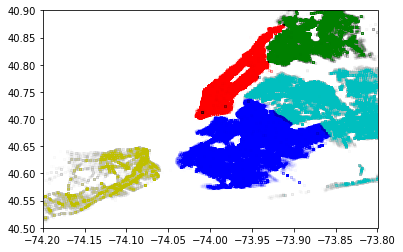

In [8]:
boroughs = tuple(df['BOROUGH'].dropna().unique())
colors = ['r','g','b','c','y']

for i, borough in enumerate(boroughs):
    plot_borough = df[df['BOROUGH'] == borough]
#     plt.subplot(111 + boroughs.index(borough)*10)    
    _ = plt.plot(plot_borough['LONGITUDE'], plot_borough['LATITUDE'], colors[i]+'.', alpha=0.005)
    _ = plt.xlim(-74.2,-73.8)
    _ = plt.ylim(40.5,40.9)
# plt.imshow(extent=[-74,-73,40,41])
plt.show()

##### Datetime conversion

In [9]:
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])
df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME'])

# df['CRASH TIME'] = (df['CRASH DATE'] + ' ' + df['CRASH TIME']).apply(lambda x: dt.datetime.strptime(x, '%m/%d/%Y %H:%M'))

In [10]:
df[['CRASH DATE','CRASH TIME']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1486656 entries, 0 to 1697571
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   CRASH DATE  1486656 non-null  datetime64[ns]
 1   CRASH TIME  1486656 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 34.0 MB


##### ZIP replacement

In [11]:
np.sort(df['ZIP CODE'].astype('str').unique())[:10]

array(['     ', '10000', '10000.0', '10001', '10001.0', '10002',
       '10002.0', '10003', '10003.0', '10004'], dtype=object)

In [12]:
empty = np.sort(df['ZIP CODE'].astype('str').unique())[0]
empty_cells = df['ZIP CODE'].isin([empty, np.nan])
df['EMPTY'] = empty_cells

In [13]:
len(empty_cells[empty_cells==True])

343500

In [14]:
# build zip code search function
search = SearchEngine(simple_zipcode=True)
def get_zipcode(lat,lng):
    result = search.by_coordinates(lat = lat, lng = lng, returns = 1)
    return int(result[0].zipcode)

In [15]:
for i,j in df.loc[df['EMPTY'] == True, ['LATITUDE', 'LONGITUDE']].drop_duplicates().values:
    df.loc[(df['LATITUDE'] == i) & (df['LONGITUDE'] == j), 'ZIP CODE'] = get_zipcode(i,j)

In [16]:
empty = np.sort(df['ZIP CODE'].astype('str').unique())[0]
empty_cells = df['ZIP CODE'].isin([empty, np.nan])
len(empty_cells[empty_cells==True])

7

##### Fill borough data

In [17]:
len(df[df['BOROUGH'].isnull()])

343268

In [18]:
manhattan_zips = [
    10026,10027,10030,10037,10039, # Harlem
    10001,10011,10018,10019,10020,10036, # Chelsea/Clinton
    10029,10035, #East Harlem
    10010,10016, 10017, 10022, # Grammercy Park/Murray Hill
    10012, 10013, 10014, # Greenwich Village/SoHo
    10004, 10005, 10006, 10007, 10038, 10280, # Lower Manhattan
    110002, 10003, 10009, # Lower East Side
    10021, 10028, 10044, 10065, 10075, 10128, # Upper East Side
    10023, 10024, 10025, # Upper West Side
    10031, 10032, 10033, 10034, 10040 # Inwood/Washington Heights
]

brooklyn_zips = [
    11212, 11213, 11216, 11233, 11238, # Central Brooklyn
    11209, 11214, 11228, # Southwest Brooklyn
    11204, 11218, 11219, 11230, # Borough Park
    11234, 11236, 11239, # Canarsie/Flatlands
    11223, 11224, 11229, 11235, # Southern Brooklyn
    11201, 11205, 11215, 11217, 11231, # Northwest Brooklyn
    11203, 11210, 11225, 11226, # Flatbush
    11207, 11208, # East New York/New Lots
    11211, 11222, # Greenpoint
    11220, 11232, # Sunset Park
    11206, 11221, 11237 # Bushwick/Williamsburg
]

queens_zips = [
    11361, 11362, 11363, 11364, # Northeast Queens
    11354, 11355, 11356, 11357, 11358, 11359, 11360, # North Queens
    11365, 11366, 11367, # Central Queens
    11412, 11423, 11432, 11433, 11434, 11435, 11436, # Jamaica
    11101, 11102, 11103, 11104, 11105, 11106, # Northwest Queens
    11374, 11375, 11379, 11385, # West Central Queens
    11691, 11692, 11693, 11694, 11695, 11697, # Rockaways
    11004, 11005, 11411, 11413, 11422, 11426, 11427, 11428, 11429, # Southeast Queens
    11414, 11415, 11416, 11417, 11418, 11419, 11420, 11421, # Southwest Queens
    11368, 11369, 11370, 11372, 11373, 11377, 11378 # West Queens
]

si_zips = [
    10302, 10303, 10310, # Port Richmond
    10306, 10307, 10308, 10309, 10312, # South Shore
    10301, 10304, 10305, # Stapleton/St. George
    10314 # Mid-Island
]

bronx_zips = [
    10453, 10457, 10460, # Central Bronx
    10458, 10467, 10468, # Bronx Park/Fordham
    10451, 10452, 10456, # High Bridge/Morrisania
    10454, 10455, 10459, 10474, # Hunts Point/Mott Haven
    10463, 10471, # Kingsbridge/Riverdale
    10466, 10469, 10470, 10475, # Northeast Bronx
    10461, 10462,10464, 10465, 10472, 10473 # Southeast Bronx
]

In [19]:
boroughs = ['MANHATTAN','BROOKLYN','QUEENS','STATEN ISLAND','BRONX']
zips = [manhattan_zips, brooklyn_zips, queens_zips, si_zips, bronx_zips]

for borough, zip_code in zip(boroughs, zips):
    df.loc[df['ZIP CODE'].isin(zip_code), 'BOROUGH'] = borough

In [20]:
len(df[df['BOROUGH'].isnull()])

16399

##### Add columns

In [21]:
# add RUSH HOUR column for hours between 6-10 AM and 4-8 PM
df['RUSH HOUR'] = 0

morning_rush = (df['CRASH TIME'].dt.time > dt.time(5,0)) & (df['CRASH TIME'].dt.time < dt.time(10,0))
afternoon_rush = (df['CRASH TIME'].dt.time > dt.time(16,0)) & (df['CRASH TIME'].dt.time < dt.time(20,0))

df.loc[(morning_rush == True) | (afternoon_rush == True), 'RUSH HOUR'] = 1

In [22]:
# add SEASON column based on meteorological definition
df.loc[df['CRASH DATE'].dt.month.isin([3,4,5]) == True, 'SEASON'] = 'spring'
df.loc[df['CRASH DATE'].dt.month.isin([6,7,8]) == True, 'SEASON'] = 'summer'
df.loc[df['CRASH DATE'].dt.month.isin([9,10,11]) == True, 'SEASON'] = 'fall'
df.loc[df['CRASH DATE'].dt.month.isin([12,1,2]) == True, 'SEASON'] = 'winter'

In [23]:
df[['CRASH DATE','RUSH HOUR','SEASON']].sample(5)

,CRASH DATE,RUSH HOUR,SEASON
532019,2018-11-15,0,fall
900268,2017-10-12,1,fall
733077,2016-04-27,0,spring
243951,2016-09-15,1,fall
86683,2017-05-14,0,spring


In [24]:
location = astral.LocationInfo(name='New York', region='New York', timezone='America/New_York', latitude=40.7, longitude=-74)

def get_sunrise_sunset(sun_action, time_zone, crash_date):
    time = sun(location.observer, tzinfo=time_zone, date=crash_date.date())[sun_action].time()
    return time

In [25]:
df['SUNRISE'] = df.apply(lambda x: get_sunrise_sunset(sun_action='sunrise',\
                                                      time_zone='America/New_York',\
                                                      crash_date=x['CRASH DATE']), axis=1)
df['SUNSET'] = df.apply(lambda x: get_sunrise_sunset(sun_action='sunset',\
                                                     time_zone='America/New_York',\
                                                     crash_date=x['CRASH DATE']), axis=1)

In [26]:
df['DURING DAYTIME'] = 0
after_sunrise = (df['CRASH TIME'].dt.time > df['SUNRISE']) & (df['CRASH TIME'].dt.time < df['SUNSET'])
df.loc[after_sunrise == True, 'DURING DAYTIME'] = 1

In [27]:
df[['CRASH TIME','SUNRISE','SUNSET','DURING DAYTIME']].sample(5)

,CRASH TIME,SUNRISE,SUNSET,DURING DAYTIME
19376,2021-01-04 12:10:00,05:24:33.211620,20:27:54.627486,1
1337356,2021-01-04 17:30:00,06:36:33.161158,19:22:34.936035,1
1043262,2021-01-04 15:20:00,06:20:04.476826,19:33:10.181265,1
123560,2021-01-04 15:35:00,07:06:27.979954,16:28:13.014377,1
1556061,2021-01-04 13:35:00,06:23:35.818078,17:51:49.024326,1


In [28]:
# add TOTAL PEDESTRIAN CASUALTIES target variable
df['TOTAL PEDESTRIAN CASUALTIES'] = df['NUMBER OF PEDESTRIANS INJURED'] + df['NUMBER OF PEDESTRIANS KILLED'] + df['NUMBER OF CYCLIST INJURED'] + df['NUMBER OF CYCLIST KILLED']

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1486656 entries, 0 to 1697571
Data columns (total 36 columns):
 #   Column                         Non-Null Count    Dtype         
---  ------                         --------------    -----         
 0   CRASH DATE                     1486656 non-null  datetime64[ns]
 1   CRASH TIME                     1486656 non-null  datetime64[ns]
 2   BOROUGH                        1470257 non-null  object        
 3   ZIP CODE                       1486656 non-null  object        
 4   LATITUDE                       1486656 non-null  float64       
 5   LONGITUDE                      1486656 non-null  float64       
 6   LOCATION                       1486656 non-null  object        
 7   ON STREET NAME                 1203377 non-null  object        
 8   CROSS STREET NAME              980930 non-null   object        
 9   OFF STREET NAME                221574 non-null   object        
 10  NUMBER OF PERSONS INJURED      1486641 non-null  float

In [30]:
# add weekdays
weekdays = ['SUNDAY','MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY','SATURDAY']
df['WEEKDAY'] = df['CRASH DATE'].apply(lambda x: weekdays[x.weekday()])
df['WEEKDAY'].sample(10)

500927      THURSDAY
82260         FRIDAY
1492283     THURSDAY
87619       SATURDAY
1221036       FRIDAY
1438616    WEDNESDAY
985268       TUESDAY
1380464     THURSDAY
1367255       MONDAY
1143147     THURSDAY
Name: WEEKDAY, dtype: object

In [31]:
# add weekend dummy
df['WEEKEND'] = 0
weekend = df['WEEKDAY'].isin(['SATURDAY','SUNDAY'])
df.loc[weekend == True, 'WEEKEND'] = 1

##### Add holiday distance data

In [32]:
# df = pd.read_csv(r'data/clean_df.csv.gz', index_col=0)
# df['CRASH DATE'] = df['CRASH DATE'].astype('datetime64')
# df['CRASH TIME'] = df['CRASH TIME'].astype('datetime64')
# df.head()

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1486656 entries, 0 to 1697571
Data columns (total 38 columns):
 #   Column                         Non-Null Count    Dtype         
---  ------                         --------------    -----         
 0   CRASH DATE                     1486656 non-null  datetime64[ns]
 1   CRASH TIME                     1486656 non-null  datetime64[ns]
 2   BOROUGH                        1470257 non-null  object        
 3   ZIP CODE                       1486656 non-null  object        
 4   LATITUDE                       1486656 non-null  float64       
 5   LONGITUDE                      1486656 non-null  float64       
 6   LOCATION                       1486656 non-null  object        
 7   ON STREET NAME                 1203377 non-null  object        
 8   CROSS STREET NAME              980930 non-null   object        
 9   OFF STREET NAME                221574 non-null   object        
 10  NUMBER OF PERSONS INJURED      1486641 non-null  float

In [34]:
christmases = df['CRASH DATE'].apply(lambda x: dt.datetime(x.year,12,25))
new_years = df['CRASH DATE'].apply(lambda x: dt.datetime(x.year,1,1))
independence_days = df['CRASH DATE'].apply(lambda x: dt.datetime(x.year,7,4))
christmases.sample(5)

877498    2016-12-25
588895    2018-12-25
408159    2019-12-25
1493339   2013-12-25
459642    2019-12-25
Name: CRASH DATE, dtype: datetime64[ns]

In [35]:
df['DAYS FROM NEW YEARS'] = df['CRASH DATE'] - new_years
df['DAYS FROM CHRISTMAS'] = df['CRASH DATE'] - christmases
df['DAYS FROM JULY 4'] = df['CRASH DATE'] - independence_days

In [36]:
df.sample(5)

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,SEASON,SUNRISE,SUNSET,DURING DAYTIME,TOTAL PEDESTRIAN CASUALTIES,WEEKDAY,WEEKEND,DAYS FROM NEW YEARS,DAYS FROM CHRISTMAS,DAYS FROM JULY 4
260775,2016-08-26,2021-01-04 07:22:00,QUEENS,11691,40.596325,-73.76673,POINT (-73.76673 40.596325),BEACH 34 STREET,SEAGIRT BOULEVARD,NaN,...,summer,06:17:52.763982,19:36:41.183058,1,0,THURSDAY,0,238 days,-121 days,53 days
921165,2017-08-30,2021-01-04 16:00:00,BROOKLYN,11206,40.694150,-73.94027,POINT (-73.94027 40.69415),MARCUS GARVEY BOULEVARD,HART STREET,NaN,...,summer,06:21:33.347035,19:30:46.235682,1,0,TUESDAY,0,241 days,-117 days,57 days
259811,2016-08-17,2021-01-04 17:30:00,MANHATTAN,10002,40.723010,-73.98576,POINT (-73.98576 40.72301),EAST 2 STREET,AVENUE A,NaN,...,summer,06:09:02.090921,19:50:08.604897,1,0,TUESDAY,0,229 days,-130 days,44 days
540898,2018-11-25,2021-01-04 13:00:00,BRONX,10460,40.840836,-73.87258,POINT (-73.87258 40.840836),BRONX RIVER PARKWAY,NaN,NaN,...,fall,06:54:29.598149,16:31:14.898722,1,0,SATURDAY,1,328 days,-30 days,144 days
645191,2016-06-30,2021-01-04 13:20:00,QUEENS,11411,40.696360,-73.74459,POINT (-73.74459 40.69636),NASHVILLE BOULEVARD,LINDEN BOULEVARD,NaN,...,summer,05:28:38.787048,20:30:47.119423,1,0,WEDNESDAY,0,181 days,-178 days,-4 days


### Factor clean-up

In [37]:
with pd.option_context('display.max_rows', None):
    print(df['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().sort_values(ascending=False))

Unspecified                                              533262
Driver Inattention/Distraction                           286915
Failure to Yield Right-of-Way                             87915
Following Too Closely                                     74909
Backing Unsafely                                          58683
Other Vehicular                                           47237
Fatigued/Drowsy                                           37313
Passing or Lane Usage Improper                            37183
Turning Improperly                                        36381
Passing Too Closely                                       35286
Unsafe Lane Changing                                      28539
Traffic Control Disregarded                               22899
Driver Inexperience                                       22196
Lost Consciousness                                        16774
Alcohol Involvement                                       14387
Pavement Slippery                       

In [38]:
# Remove all factors that cannot be prevented by a cop
preventables = [
    'Unspecified',
    'Driver Inattention/Distraction',
    'Failure to Yield Right-of-Way',
    'Following Too Closely',
    'Backing Unsafely',
    'Other Vehicular',
    'Passing or Lane Usage Improper',
    'Turning Improperly',
    'Passing Too Closely',
    'Unsafe Lane Changing',
    'Traffic Control Disregarded',
    'Driver Inexperience',
    'Alcohol Involvement',
    'Unsafe Speed',
    'Reaction to Uninvolved Vehicle',
    'Prescription Medication',
    'Outside Car Distraction',
    'Oversized Vehicle',
    'View Obstructed/Limited',
    'Passenger Distraction',
    'Aggressive Driving/Road Rage',
    'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion',
    'Failure to Keep Right',
    'Other Electronic Device',
    'Reaction to Other Uninvolved Vehicle',
    'Animals Action',
    'Lane Marking Improper/Inadequate',
    'Traffic Control Device Improper/Non-Working',
    'Drugs (illegal)',
    'Drugs (Illegal)',
    'Cell Phone (hand-Held)',
    'Cell Phone (hands-free)',
    'Other Lighting Defects',
    'Using On Board Navigation Device',
    'Headlights Defective',
    'Eating or Drinking',
    'Tinted Windows',
    'Cell Phone (hand-held)',
    'Windshield Inadequate',
    'Texting',
    'Listening/Using Headphones'
]

df = df[df['CONTRIBUTING FACTOR VEHICLE 1'].isin(preventables)]
df.shape

(1382598, 41)

### Street name clean

In [41]:
alt_terms = ['STREET',
             'AVENUE',
             'BOULEVARD',
             'ROAD',
             'DRIVE',
             'PARKWAY',
             'EXPRESSWAY'
            ]
clean_terms = ['ST',
               'AVE',
               'BLVD',
               'RD',
               'DR',
               'PKWY',
               'EXPWY'
              ]
def alt_terms_clean(string):
    for alt, clean in zip(alt_terms, clean_terms):
        string = string.strip().upper().replace(alt, clean)
    return string

In [42]:
df['ON STREET NAME'].fillna('', inplace=True)
df['ON STREET NAME'] = df['ON STREET NAME'].map(alt_terms_clean)

df['CROSS STREET NAME'].fillna('', inplace=True)
df['CROSS STREET NAME'] = df['CROSS STREET NAME'].map(alt_terms_clean)

In [43]:
df.to_csv(r'../data/clean_df.csv.gz')